## 변경사항
+ 인코더-디코더 구조에서 Only-디코더 구조로 변경하였다.
+ 고정된 포지셔널 인코딩이 아닌 학습가능한 포지셔널 임베딩을 사용하였다.
+ 인코더-디코더 어텐션을 제거하였다.
+ ~~질문(Q)과 답변(A)을 구분자로 연결하여 단일 시퀀스로 처리하였다.~~ -> pretrain과정이므로 그냥 Q,A를 별개의 시퀀스로만 구성
+ 출력층에 일반 밀집층이 아닌 임베딩 행렬의 전치를 곱함

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## csv 파일 로드 및 전처리

In [2]:
csv_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData_.csv'

df = pd.read_csv(csv_path)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
def preprocess_korean_sentence(sentences):
    preprocessed_setences = []
    for sentence in sentences:
        sentence = sentence.strip()

        # SubwordTextEncoder는 구두점을 따로 제거하지 않기 때문에
        # 필요한 구두점(.,!?)만 유지하고 없앰
        sentence = re.sub(r"([.,!?])", r" \1 ", sentence)
        # 여러 공백은 하나로 치환
        sentence = re.sub(r"\s+", " ", sentence)
        # 허용 문자만 남기고 나머지는 공백으로 치환
        sentence = re.sub(r"[^가-힣a-zA-Z0-9.,!? ]", " ", sentence)
        
        preprocessed_setences.append(sentence.strip())

    return preprocessed_setences

In [4]:
questions = preprocess_korean_sentence(df['Q'])
answers = preprocess_korean_sentence(df['A'])

In [5]:
# 질문과 대답을 하나의 리스트로 합침(pretrain을 위한 데이터셋 구축)
combined_texts = questions + answers

In [6]:
print(combined_texts[10])
print(combined_texts[10 + 11823])

SNS보면 나만 빼고 다 행복해보여
자랑하는 자리니까요 .


### 토큰화 및 정수 인코딩
+ SubwordTextEncoder를 이용하여 토큰화 및 정수 인코딩

In [7]:
# tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#     questions + answers, target_vocab_size=2**13
# )

# # 토크나이저 저장
# tokenizer.save_to_file('tokenizer_subword')

In [8]:
# 토크나이저 불러오기
tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file('../../Exploration/Quest07/tokenizer_subword')

In [9]:
# 시작 토큰과 종료 토큰 추가
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8166


In [11]:
# 토큰화 및 정수 인코딩
def text_vectorization(texts):
  tokenized_texts = []
  
  for text in texts:
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    tokenized_text = START_TOKEN + tokenizer.encode(text) + END_TOKEN
    tokenized_texts.append(tokenized_text)

  return tokenized_texts

In [12]:
tokenized_combined_texts = text_vectorization(combined_texts)

In [13]:
# 인코딩 결과 확인
print(tokenized_combined_texts[10])
print(tokenizer.decode(tokenized_combined_texts[10][1:-1]))

[8164, 5770, 483, 195, 2975, 45, 3810, 8165]
SNS보면 나만 빼고 다 행복해보여


+ 길이 분포를 확인하여 최대 길이를 지정

In [14]:
text_lengths = [len(text) for text in tokenized_combined_texts]

In [15]:
print(f'Corpus 최소 길이: {min(text_lengths)}, 최대 길이: {max(text_lengths)}, 평균 길이: {np.mean(text_lengths)}')

Corpus 최소 길이: 3, 최대 길이: 31, 평균 길이: 7.653302884208745


In [16]:
max_sequence_length = 31

# 최대 길이에 맞추어 패딩
inputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_combined_texts, maxlen=max_sequence_length, padding='post')

In [17]:
inputs

array([[8164, 7903, 4199, ...,    0,    0,    0],
       [8164, 7957,   47, ...,    0,    0,    0],
       [8164, 7959, 1433, ...,    0,    0,    0],
       ...,
       [8164, 5207,  287, ...,    0,    0,    0],
       [8164,   14, 3191, ...,    0,    0,    0],
       [8164,  221,  554, ...,    0,    0,    0]], dtype=int32)

### 입력, 타겟 시퀀스 생성

In [18]:
# 입력 시퀀스와 타겟 시퀀스 생성
# 언어 모델링을 위해 입력은 토큰 0~(n-1), 타겟은 토큰 1~n
def create_lm_dataset(sequences):
    input_sequences = []
    target_sequences = []
    
    for seq in sequences:
        # 입력: 마지막 토큰을 제외한 시퀀스
        input_seq = seq[:-1]
        # 타겟: 첫 번째 토큰을 제외한 시퀀스
        target_seq = seq[1:]

        input_sequences.append(input_seq)
        target_sequences.append(target_seq)

    return np.array(input_sequences), np.array(target_sequences)

In [19]:
inputs, outputs = create_lm_dataset(inputs)

## 트랜스포머 모델 구성

## 층별 구성

In [20]:
# 포지셔널 임베딩 층
# 기존 고정된 포지셔널 인코딩에서 학습가능한 포지셔널 임베딩 층으로 변경
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_position, d_model):
        super().__init__()
        self.w = self.add_weight(
            shape = (max_position, d_model),
            initializer="random_normal",
            trainable=True,
        )
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1] # 입력 시퀀스 길이만큼 잘라서 더해줘야함
        position_embeddings = self.w[:seq_len, :]  # 먼저 필요한 길이만큼 잘라내고
        position_embeddings = tf.expand_dims(position_embeddings, 0)  # 배치 차원 추가
        return inputs + position_embeddings

In [21]:
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬연산을 위한 멀티 헤드 분리
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에 Dense를 한 번 더 적용
    outputs = self.dense(concat_attention)

    return outputs

In [23]:
def create_padding_mask(seq):
  padding_mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return padding_mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
def create_look_ahead_mask(seq_len):
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  return look_ahead_mask

In [25]:
# gpt 모델은 디코더 블록만을 사용한 구조
# 두 개의 서브 레이어(셀프 어텐션, 포지션-와이즈 FFNN)로 구성
# 기존 인코더의 입력 매개변수를 제거
# (기능이랑은 관련 x) look_ahead_mask와 padding_mask 대신 단일 attention_mask 사용
def gpt_block(dff, d_model, num_heads, dropout, name="gpt_block"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  attention_mask = tf.keras.Input(shape=(1, None, None), name="attention_mask")

  # 첫 번째 서브 레이어 : 셀프 어텐션
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': attention_mask
      })

  # LayerNormalization
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  ''' 
  
  기존 인코더 - 디코더 어텐션을 제거
  
  '''

  # 두 번째 서브 레이어 : 2개의 완전연결층(피드포워드 신경망)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention) 
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout, LayerNormalization
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention)

  return tf.keras.Model(
      inputs=[inputs, attention_mask], # 인코더와 연결된 입력을 제거
      outputs=outputs,
      name=name)

In [26]:
# 출력층의 가중치 공유레이어를 정의
class SharedWeightsLayer(tf.keras.layers.Layer):
    def __init__(self, shared_weights):
        super().__init__()
        self.shared_weights = shared_weights
    
    def call(self, inputs):
        return tf.matmul(inputs, self.shared_weights, transpose_b=True)

### 최종 모델

In [27]:
def gpt_model(vocab_size,
                num_layers,
                dff, # units -> dff로 논문 표기대로 변경
                d_model,
                num_heads,
                max_position, # 포지셔널 임베딩을 위해 시퀀스 최대 길이 전달(기존 방법보다 더 정확한 방법)
                dropout,
                name="gpt-1"):
  # 기존 인코더, 디코더 입력 -> 디코더 입력으로 통일
  inputs = tf.keras.Input(shape=(None,), dtype=tf.int32, name="inputs") # 정수 인코딩된 시퀀스 입력

  # 마스크 생성
  # 기존 방식에서 각 함수별 역할을 명학하게 분리
  padding_mask = create_padding_mask(inputs)

  seq_length = tf.shape(inputs)[1]
  look_ahead_mask = create_look_ahead_mask(seq_length)

  # 두 마스크 결합
  look_ahead_mask = tf.expand_dims(tf.expand_dims(look_ahead_mask, 0), 1)
  combined_mask = tf.maximum(padding_mask, look_ahead_mask)
    
  # 임베딩 레이어(출력층에서 사용을 위해 임베딩 층을 별도로 저장)
  embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model)
  token_embeddings = embedding_layer(inputs)
  token_embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 임베딩
  embeddings = PositionalEmbedding(max_position, d_model)(token_embeddings)

  # Dropout
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 블록 쌓기
  for i in range(num_layers):
    outputs = gpt_block(
        dff=dff,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='gpt_block_{}'.format(i),
    )(inputs=[outputs, combined_mask]) # 간단해진 입력

  # 출력층
  # embeddings 가중치를 공유하여 행렬곱
  logits = SharedWeightsLayer(embedding_layer.weights[0])(outputs)

  return tf.keras.Model(inputs=inputs, outputs=logits, name=name)

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
DFF = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율
MAX_POSITION = max_sequence_length # 최대 길이를 하이퍼파라미터로 추가

# 모델 생성
model = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    max_position=MAX_POSITION,
    dropout=DROPOUT
)

model.summary()

Model: "gpt-1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           inputs[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli ()                   0           tf.compat.v1.shape[0][0]         
__________________________________________________________________________________________________
tf.ones (TFOpLambda)            (None, None)         0           tf.__operators__.getitem_1[0][0] 
                                                                 tf.__operators__.getitem_1[0]

## 모델 훈련

In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': inputs},
    outputs
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [30]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_sequence_length - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

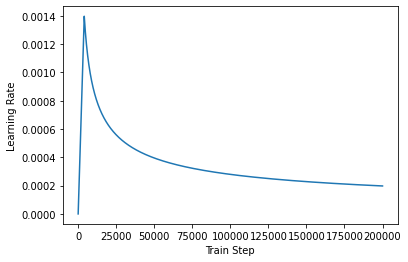

In [32]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [33]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_sequence_length - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [34]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
370/370 [==============================] - 21s 44ms/step - loss: 1.6799 - accuracy: 0.1411
Epoch 2/20
370/370 [==============================] - 16s 44ms/step - loss: 1.3939 - accuracy: 0.0493
Epoch 3/20
370/370 [==============================] - 17s 45ms/step - loss: 1.2925 - accuracy: 0.0560
Epoch 4/20
370/370 [==============================] - 16s 45ms/step - loss: 1.2057 - accuracy: 0.0607
Epoch 5/20
370/370 [==============================] - 17s 45ms/step - loss: 1.1245 - accuracy: 0.0661
Epoch 6/20
370/370 [==============================] - 17s 45ms/step - loss: 1.0465 - accuracy: 0.0724
Epoch 7/20
370/370 [==============================] - 17s 45ms/step - loss: 0.9725 - accuracy: 0.0785
Epoch 8/20
370/370 [==============================] - 17s 46ms/step - loss: 0.9054 - accuracy: 0.0841
Epoch 9/20
370/370 [==============================] - 17s 46ms/step - loss: 0.8459 - accuracy: 0.0892
Epoch 10/20
370/370 [==============================] - 17s 46ms/step - loss: 0.795

### 훈련 결과 시각화

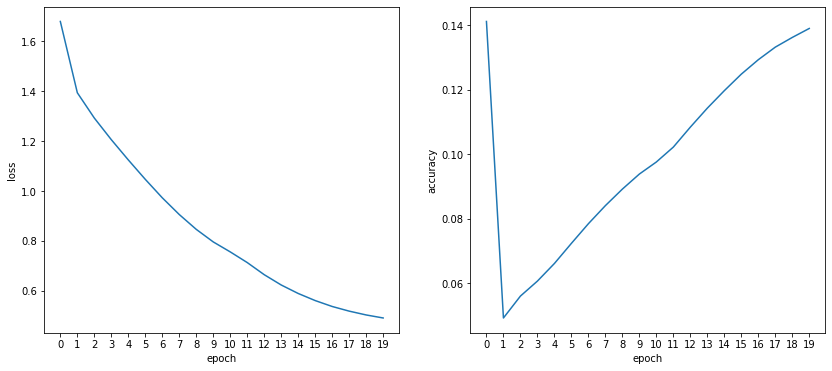

In [35]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

fig, axis = plt.subplots(1,2, figsize = (14, 6))
axis[0].plot(train_loss)
axis[0].set_xlabel('epoch')
axis[0].set_ylabel('loss')
axis[0].set_xticks(range(len(train_loss)))
axis[1].plot(train_acc)
axis[1].set_xlabel('epoch')
axis[1].set_ylabel('accuracy')
axis[1].set_xticks(range(len(train_loss)))

## 추론 함수 정의

In [36]:
def generate_text(model, start_text, max_length=max_sequence_length, temperature=1.0): # 언어모델임을 고려하여 temperature 정의
    # 시작 텍스트 전처리
    start_text = preprocess_korean_sentence([start_text])[0]
    input_tokens = START_TOKEN + tokenizer.encode(start_text)
    input_tokens = tf.expand_dims(input_tokens, 0)
    
    # 결과 텍스트
    result = start_text
    
    # 텍스트 생성
    for _ in range(max_length):
        # 입력이 너무 길면 자름
        if input_tokens.shape[1] > max_sequence_length:
            input_tokens = input_tokens[:, -max_sequence_length:]
        
        # 다음 단어 예측
        predictions = model(input_tokens)
        predictions = predictions[:, -1, :]  # 마지막 토큰의 예측만 사용
        
        # 확률 분포 조정
        if temperature != 1.0:
            predictions = predictions / temperature
        
        # 다음 단어 샘플링
        predicted_id = tf.random.categorical(predictions, num_samples=1)
        
        # 종료 토큰이 나오면 중단
        if predicted_id == END_TOKEN[0]:
            break
        
        # 예측된 토큰을 입력에 추가
        input_tokens = tf.cast(input_tokens, tf.int32) # 타입불일치 에러가 나서 양 데이터 타입 일치
        predicted_id = tf.cast(predicted_id, tf.int32)
        
        input_tokens = tf.concat([input_tokens, predicted_id], axis=1)
        
        # 예측된 토큰을 결과에 추가
        predicted_token = tokenizer.decode([predicted_id.numpy()[0][0]])
        result += predicted_token
    
    return result

## 입력문장 테스트

In [40]:
test_prompts = ["3박 4일", "SNS", "오늘 학교에서", "오늘 하루", "밥먹고"]

for prompt in test_prompts:
    generated = generate_text(model, prompt, max_length=30, temperature=0.5)
    print(f"프롬프트: '{prompt}'")
    print(f"생성된 텍스트: '{generated}'", end='\n\n')

프롬프트: '3박 4일'
생성된 텍스트: '3박 4일 정도 놀러가고 싶다'

프롬프트: 'SNS'
생성된 텍스트: 'SNS보면 나만 빼고 다 행복해보여'

프롬프트: '오늘 학교에서'
생성된 텍스트: '오늘 학교에서만 사랑해주세요 .'

프롬프트: '오늘 하루'
생성된 텍스트: '오늘 하루였어도 잘 갔는데'

프롬프트: '밥먹고'
생성된 텍스트: '밥먹고는 뭐하나'

